## Overview

Given PCA coordinates generate a figure that captures the main structure identified.

In [2]:
import gcsfs
import zarr
import intake
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs

/opt/conda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
from ag3 import release_data
v3 = release_data()

In [4]:
all_meta = v3.load_sample_set_metadata(v3.all_wild_sample_sets)

/opt/conda/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [5]:
all_meta.columns

Index(['partner_sample_id', 'contributor', 'country', 'location', 'year',
       'month', 'latitude', 'longitude', 'sex_call', 'sample_set',
       'aim_fraction_colu', 'aim_fraction_arab', 'species_gambcolu_arabiensis',
       'species_gambiae_coluzzii', 'is_arabiensis', 'is_gamb_colu',
       'is_gambiae', 'is_coluzzii'],
      dtype='object')

In [6]:
df_species_samples = all_meta.query("species_gambcolu_arabiensis == 'gamb_colu'")
df_species_samples.head()

,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,sample_set,aim_fraction_colu,aim_fraction_arab,species_gambcolu_arabiensis,species_gambiae_coluzzii,is_arabiensis,is_gamb_colu,is_gambiae,is_coluzzii
sample_id,,,,,,,,,,,,,,,,,,
AR0047-C,LUA047,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.945,0.001,gamb_colu,coluzzii,False,True,False,True
AR0049-C,LUA049,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.933,0.001,gamb_colu,coluzzii,False,True,False,True
AR0051-C,LUA051,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.937,0.002,gamb_colu,coluzzii,False,True,False,True
AR0061-C,LUA061,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.938,0.002,gamb_colu,coluzzii,False,True,False,True
AR0078-C,LUA078,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.926,0.001,gamb_colu,coluzzii,False,True,False,True


In [7]:
longitude_min = df_species_samples.longitude.min()
longitude_max = df_species_samples.longitude.max()

latitude_min = df_species_samples.latitude.min()
latitude_max = df_species_samples.latitude.max()

longitude_width = longitude_max - longitude_min
latitude_height = latitude_max - latitude_min

In [8]:
BBox = (longitude_min, longitude_max,      
         latitude_min, latitude_max)

In [9]:
# From https://stackoverflow.com/questions/56328254/how-to-make-the-conversion-from-barycentric-coordinates-to-cartesian-coordinates
b = np.array([0.25,0.3,0.45]) # Barycentric coordinates
t = np.transpose(np.array([[0,0],[1,0],[0,1]])) # Triangle
c = t.dot(b)
c

array([0.3 , 0.45])

/opt/conda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/opt/conda/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


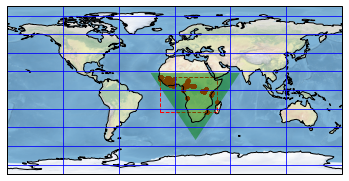

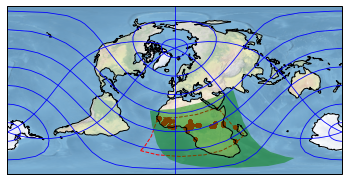

In [10]:
map_types = [
    {'projection': ccrs.PlateCarree(), 'transform': ccrs.PlateCarree()},
    {'projection': ccrs.RotatedPole(pole_latitude=45, pole_longitude=180), 'transform': ccrs.Geodetic()}
]
for map_type in map_types:
    ax = plt.axes(projection=map_type['projection'])
    ax.stock_img()

    #ax.set_xlim(BBox[0] - 40, BBox[1] + 40)
    #ax.set_ylim(BBox[2] - 40, BBox[3] + 40)

    ax.scatter(
                df_species_samples.longitude,
                df_species_samples.latitude,
                zorder=1, alpha= 0.2, c='r', s=10,
                transform=map_type['transform']
    )

    ax.add_patch(
                    mpatches.Rectangle(
                        xy=[longitude_min, latitude_min], width=longitude_width, height=latitude_height,
                        edgecolor='red',
                        linestyle='--',
                        fill=False,
                        transform=map_type['transform']
                    )
                 )

    ax.add_patch(
                    mpatches.Polygon(
                        xy=[
                            [longitude_min - 10, latitude_max + 5],
                            [longitude_max + 25, latitude_max + 5],
                            [longitude_max / 2, latitude_min - 30]
                        ],
                        closed=True,
                        facecolor='green',
                        alpha=0.5, 
                        transform=map_type['transform']
                    )

                 )

    ax.gridlines(color='blue')
    ax.coastlines()

    plt.show()

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import math

def abc_to_rgb(A=0.0,B=0.0,C=0.0):
    ''' Map values A, B, C (all in domain [0,1]) to
    suitable red, green, blue values.'''
    return (min(B+C,1.0),min(A+C,1.0),min(A+B,1.0))

def plot_legend():
    ''' Plots a legend for the colour scheme
    given by abc_to_rgb. Includes some code adapted
    from http://stackoverflow.com/a/6076050/637562'''

    # Basis vectors for triangle
    basis = np.array([[0.0, 1.0], [-1.5/np.sqrt(3), -0.5],[1.5/np.sqrt(3), -0.5]])

    fig = plt.figure()
    ax = fig.add_subplot(111,aspect='equal')

    # Plot points
    a, b, c = np.mgrid[0.0:1.0:50j, 0.0:1.0:50j, 0.0:1.0:50j]
    a, b, c = a.flatten(), b.flatten(), c.flatten()

    abc = np.dstack((a,b,c))[0]
    print(abc.shape)
    print(basis)
    
    #abc = filter(lambda x: x[0]+x[1]+x[2]==1, abc) # remove points outside triangle
    
    #abc = map(lambda x: x/sum(x), abc) # or just make sure points lie inside triangle ...

    data = np.dot(abc, basis)
    colours = [abc_to_rgb(A=point[0],B=point[1],C=point[2]) for point in abc]

    ax.scatter(data[:,0], data[:,1],marker=',',edgecolors='none',facecolors=colours)

    # Plot triangle
    ax.plot([basis[_,0] for _ in range(3) + [0,]],[basis[_,1] for _ in range(3) + [0,]],**{'color':'black','linewidth':3})

    # Plot labels at vertices
    offset = 0.25
    fontsize = 32
    ax.text(basis[0,0]*(1+offset), basis[0,1]*(1+offset), '$A$', horizontalalignment='center',
            verticalalignment='center', fontsize=fontsize)
    ax.text(basis[1,0]*(1+offset), basis[1,1]*(1+offset), '$B$', horizontalalignment='center',
            verticalalignment='center', fontsize=fontsize)
    ax.text(basis[2,0]*(1+offset), basis[2,1]*(1+offset), '$C$', horizontalalignment='center',
            verticalalignment='center', fontsize=fontsize)    

    ax.set_frame_on(False)
    ax.set_xticks(())
    ax.set_yticks(())

    plt.show()

(125000, 3)
[[ 0.         1.       ]
 [-0.8660254 -0.5      ]
 [ 0.8660254 -0.5      ]]


TypeError: unsupported operand type(s) for +: 'range' and 'list'

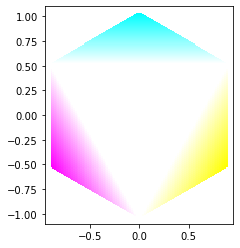

In [20]:
plot_legend()

In [21]:
abc_to_rgb(1, 0, .04)

(0.04, 1.0, 1)

In [23]:
# https://stackoverflow.com/questions/31967472/smooth-interpolated-tertiary-or-quaternary-colour-scales-e-g-r-g-b-triangle

# we can assume that all lat lons fall within this triangle.
x = ccrs.Geodetic()


In [25]:
x.transform_point(ccrs.Geodetic, 0, 0)

TypeError: must be real number, not type